# CountGPVAE Simulation Demo

This notebook demonstrates how to use the modularized components of the CountGPVAE model.

In [1]:
import os
import jax
import jax.nn as nn
import math
import itertools
from jax import lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
import plotly.express as px
import geopandas as gpd
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [2]:
# Load the spatial grid and polygon data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


## 2. Set up Model Parameters

In [3]:
# Model configuration
args = {
    "x": spatial_data["x"],
    "gp_kernel": exp_sq_kernel,
    "noise": 1.e-2,
    "jitter": 1.e-2,
    "M_lo": jnp.array(spatial_data["pol_pts_lo"]),
    "M_hi":  jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    "vae_var": 0.1,
    "batch_size": 100,
    "hidden_dim": 50,
    "z_dim": 40,
    "learning_rate": 1e-3,
    "num_epochs": 30,
    "rng_key": PRNGKey(6)
}

## 3. Generate GP Samples

In [4]:
# Create predictive function for GP
from numpyro.infer import Predictive
# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=5)(
    PRNGKey(6),
    config=args
)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

plot_process(prior_samples_arviz.prior.gp_aggr.values)

## 4. Train VAE

In [115]:
# Initialize SVI
optimizer = numpyro.optim.Adam(step_size=1e-3)
agg_gp_predictive = Predictive(gp_aggr,num_samples = 5)
@jax.jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = jax.random.fold_in(rng_key, i) #Array(2,)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = jax.random.split(rng_key_i, 4) #Tuple(Array(2,) x 4)
        loss_sum, svi_state = val #val --svi_state

        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"] #(5,116) <- num_samples : 5, total_districts : 116
        #* svi is where the vae_model & vae_guide gets applied
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args["batch_size"]
        return loss_sum, svi_state

    return lax.fori_loop(lower = 0, upper = num_train, body_fun=body_fn, init_val=(0.0, svi_state))

@jax.jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = jax.random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_varm, rng_key_noise = jax.random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"]
        #* svi is where the vae_model & vae_guide gets applied
        loss = svi.evaluate(svi_state, batch) / args["batch_size"]
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(lower = 0, upper = num_test,body_fun =  body_fn, init_val = 0.0)
    loss = loss / num_test
    return loss

## Hyerparameter tuning for h and z

In [16]:
# Define hyperparameter grid
hidden_dims = [20, 30, 40, 50]
z_dims = [20, 30, 40, 50]

# Store results
test_loss_results_final = {}
test_loss_results_mean = {}

num_train = 100
num_test = 100
num_epochs = 20

for hidden_dim, z_dim in itertools.product(hidden_dims, z_dims):
    print(f"Training with hidden_dim={hidden_dim}, z_dim={z_dim}")

    args["hidden_dim"] = hidden_dim
    args["z_dim"] = z_dim

    # Initialize optimizer and SVI
    adam = numpyro.optim.Adam(step_size=args["learning_rate"])
    # Pass vae_var to vae_model using a lambda function
    svi = SVI(
        lambda batch: vae_model(batch, hidden_dim, z_dim, args["vae_var"]),
        lambda batch: vae_guide(batch, hidden_dim, z_dim),
        adam,
        RenyiELBO(),
    )

    # Split RNG keys
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"]

    # Initialize SVI state
    svi_state = svi.init(rng_key_init, init_batch)

    # Pre-allocate test loss array
    test_loss_list = jnp.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
        t_start = time.time()

        train_loss, svi_state = epoch_train(rng_key_train, svi_state, num_train)
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list = test_loss_list.at[epoch].set(test_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f} ({time.time() - t_start:.2f} s)")

        if math.isnan(test_loss):  # Stop early if NaN
            print(f"NaN encountered at hidden_dim={hidden_dim}, z_dim={z_dim}. Skipping...")
            break  # Stop training if NaN occurs

    # Store results only if valid
    if not math.isnan(test_loss_list[-1]):
        test_loss_results_final[(hidden_dim, z_dim)] = test_loss_list[-1]
        test_loss_results_mean[(hidden_dim, z_dim)] = jnp.nanmean(test_loss_list)
        print(f"Final Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {test_loss_list[-1]}")
        print(f"Mean Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {jnp.nanmean(test_loss_list)}")

print("Grid search complete.")
print("Results:", test_loss_results_final)
print("Mean Test Loss Results:", test_loss_results_mean)

Training with hidden_dim=20, z_dim=20


KeyboardInterrupt: 

### Optimal hyperparams with lowest mean test loss and pretty stable final loss is (50, 30)

In [ ]:
#-------------------------- Train VAE -------------------------- #
run = True
if run:
    adam = numpyro.optim.Adam(step_size = args["learning_rate"])
    svi = SVI(
        model=lambda batch: vae_model(batch, args["hidden_dim"], args["z_dim"], args["vae_var"]),
        guide=lambda batch: vae_guide(batch, args["hidden_dim"], args["z_dim"]),
        optim=adam,
        loss=RenyiELBO(),
    )
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"],3)
    #(num_samples, num_regions)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"] #(num_samples, num_regions) <- i.e (5,58)
    svi_state = svi.init(rng_key_init, init_batch)

    test_loss_list = []

    for i in range(args["num_epochs"]):
        rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
        t_start = time.time()
        num_train = 1000
        # Where forward/backward pass gets called for train
        train_loss , svi_state = epoch_train(rng_key_train, svi_state, num_train)
        num_test = 1000
        # Where forward/backward pass gets called for test
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list += [test_loss]

        print("Epoch : {}, train loss : {:.2f}, test loss : {:.2f} ({:.2f} s.)".format(i, train_loss, test_loss, time.time() - t_start))
        if np.isnan(test_loss):
            break

Epoch : 0, train loss : 62461775872.00, test loss : 3613909.75 (0.00 s.)
Epoch : 1, train loss : 2129245312.00, test loss : 1725565.12 (0.00 s.)
Epoch : 2, train loss : 1460391808.00, test loss : 1073098.50 (0.00 s.)
Epoch : 3, train loss : 560378112.00, test loss : 146569.41 (0.00 s.)
Epoch : 4, train loss : 72361448.00, test loss : 32610.39 (0.00 s.)
Epoch : 5, train loss : 32149790.00, test loss : 34360.36 (0.00 s.)
Epoch : 6, train loss : 32413850.00, test loss : 31477.86 (0.00 s.)
Epoch : 7, train loss : 27511496.00, test loss : 26221.64 (0.00 s.)
Epoch : 8, train loss : 28911178.00, test loss : 26865.74 (0.00 s.)
Epoch : 9, train loss : 27171366.00, test loss : 26099.65 (0.00 s.)
Epoch : 10, train loss : 28542736.00, test loss : 29742.70 (0.00 s.)
Epoch : 11, train loss : 28341240.00, test loss : 26945.03 (0.00 s.)
Epoch : 12, train loss : 27274382.00, test loss : 26384.37 (0.00 s.)
Epoch : 13, train loss : 29153156.00, test loss : 28928.93 (0.00 s.)
Epoch : 14, train loss : 2866

In [ ]:
vae_params = svi.get_params(svi_state)

In [ ]:
save_dir = "/content/model_weights/aggVAE"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"aggVAE_e{args['num_epochs']}_h{args['hidden_dim']}_z{args['z_dim']}_batch{args["batch_size"]}.pkl")

with open(save_path, "wb") as file:
    pickle.dump(vae_params, file)

print(f"VAE parameters saved to {save_path}")

VAE parameters saved to /content/model_weights/aggVAE/aggVAE_e50_h50_z30.pkl


## Run MCMC using trained VAE encoder

In [5]:
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [6]:
N = 6

def vae_sample(args):
    dec_params = args["decoder_params"]
    z_dim, h_dim = dec_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    dec_init_fn, dec_apply_fn = vae_decoder(h_dim, N)
    x_recon = dec_apply_fn(dec_params, z)
    vae_aggr = numpyro.deterministic("vae_aggr", x_recon)
    return vae_aggr

rng_key, rng_key_predict = random.split(random.PRNGKey(3))
vae_predictive = Predictive(vae_sample, num_samples = 5)
vae_draws = vae_predictive(rng_key_predict, args)["vae_aggr"]

In [133]:
plot_process(jnp.expand_dims(vae_draws, axis = 0))

In [7]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}

    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    count = config.get("count", None)

     # Total cases: pass in low prev counts, mask high prev ones as NaN
    count_mask = ~jnp.isnan(count)

    total_population = config.get('total_population', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)
    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior
    # Call gp_aggr
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    vae = numpyro.deterministic("vae", s * vae_aggr)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    # lp = numpyro.deterministic("lp", (b0 +
    #                                   aggr_gp +
    #                                   b_pop_density * pop_density +
    #                                   b_hdi * hdi_index +
    #                                   b_urban * urban_frac))  #
    lp = numpyro.deterministic("lp", nn.softplus(b0 +
                                      vae +
                                      b_pop_density * pop_density +
                                      b_hdi * hdi_index +
                                      b_urban * urban_frac))


    sigma = numpyro.sample("sigma", dist.HalfNormal(5))

    # Full predictions (no masking)
    full_pred_cases = numpyro.sample(
        "full_pred_cases",
        dist.Normal(lp, sigma))

    # Observed only where count is available
    with numpyro.handlers.mask(mask=count_mask):
        numpyro.sample(
            "pred_cases",  # not used for return
            dist.Normal(lp, sigma),
            obs=None if is_prior_pred else count)

    # Store full predictions
    numpyro.deterministic("pred_cases_out", full_pred_cases)


In [28]:
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



In [29]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [30]:
#define the BHM used
model =  prev_model_vae_aggr

#define the MCMC params used
prob = 0.95
tree = 18

In [31]:
# Define the sampler
sampler = NUTS(model, target_accept_prob = prob, max_tree_depth = tree)
mcmc = MCMC(sampler,
            num_warmup=1000,
            num_samples=1000,
            num_chains=4,
            chain_method="vectorized")

start = time.time()
mcmc.run(PRNGKey(2), config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")

sample: 100%|██████████| 2000/2000 [8:33:53<00:00, 15.42s/it]  

Time taken to run MCMC: 514 minutes


In [32]:
#save mcmc for aggVAE jkt yearly (change the year manually)
# Save the MCMC object as a pickle file
# Define the path where you want to save the MCMC files

save_dir = "../model weights/aggVAEPrev"
os.makedirs(save_dir, exist_ok=True)

# Define the file path where to save the MCMC object
file_path = os.path.join(save_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_z{args["z_dim"]}_prob{prob}_treedepth{tree}.pkl")

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2022 saved successfully at ../model weights/aggVAEPrev\mcmc_jkt_2022_514min_z40_prob0.95_treedepth18.pkl.


In [33]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.39      6.85     98.95     88.28    113.19   4377.55      1.01
             b_hdi     -0.80      1.33     -0.65     -2.67      0.92       nan      1.96
     b_pop_density      0.26      0.75      0.24     -1.20      1.30     10.48      1.11
           b_urban     -0.40      0.89     -0.23     -1.40      1.06      4.03      1.37
full_pred_cases[0]   2114.95      5.84   2115.86   2105.32   2120.55     15.90      1.09
full_pred_cases[1]    285.51    159.69    198.63    137.65    547.00      3.36      1.56
full_pred_cases[2]    114.05    151.60     18.41     -7.96    350.91      3.96      1.42
full_pred_cases[3]    373.09    164.62    298.20    215.68    635.34      3.57      1.50
full_pred_cases[4]    530.87    163.45    459.74    371.52    788.25      3.51      1.52
full_pred_cases[5]    485.76    150.87    382.15    362.58    707.41      3.31      1.58
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],2114.952,5.836,2103.200,2124.001,0.949,1.181,15.0,96.0,1.70
pred_cases_out[1],285.505,159.688,137.646,601.078,59.544,15.345,7.0,4.0,1.89
pred_cases_out[2],114.048,151.604,-11.851,400.046,51.866,17.358,11.0,133.0,2.05
pred_cases_out[3],373.090,164.616,213.051,694.093,59.340,18.597,8.0,5.0,1.79
pred_cases_out[4],530.869,163.446,371.518,848.731,59.433,17.552,7.0,4.0,1.77
pred_cases_out[5],485.760,150.870,361.969,767.102,56.540,6.822,6.0,4.0,2.16
lp[0],2114.901,4.363,2104.359,2119.692,0.929,0.822,12.0,104.0,1.77
lp[1],285.405,159.678,138.755,599.714,59.553,15.204,7.0,4.0,1.89
lp[2],113.184,152.362,0.000,397.212,52.426,17.207,9.0,5.0,1.96
lp[3],372.265,165.088,211.738,693.497,59.766,18.452,8.0,5.0,1.79


In [34]:
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 4
Average ESS for all aggVAE-low effects : 4
Max r_hat for all aggVAE-low : 1.3600000143051147
Average ESS for all aggVAE-high effects : 4
Max r_hat for all aggVAE-high : 1.3899999856948853


In [26]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [27]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["Cases"].values
    y_pred_d = group["pred_cases_num"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")

RMSE: 85.0627
MAE as % of average observed prevalence: 34.96%


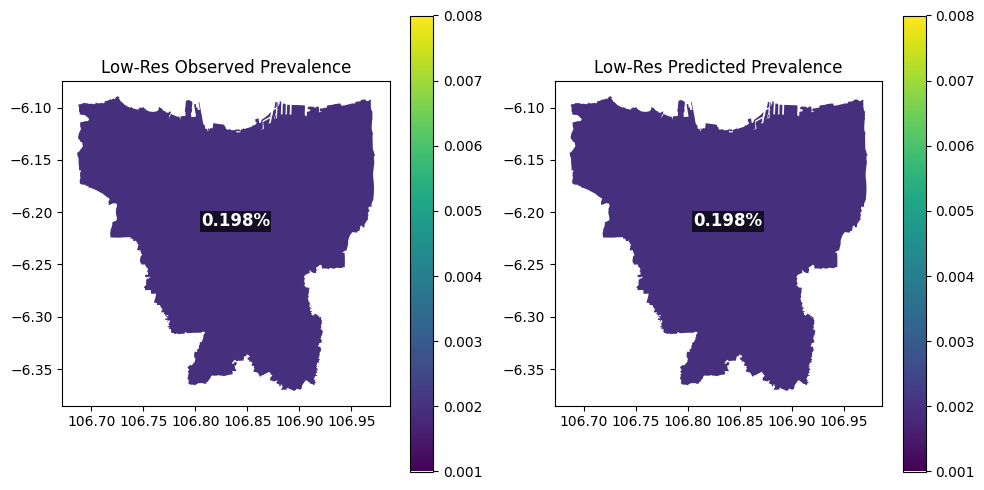

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

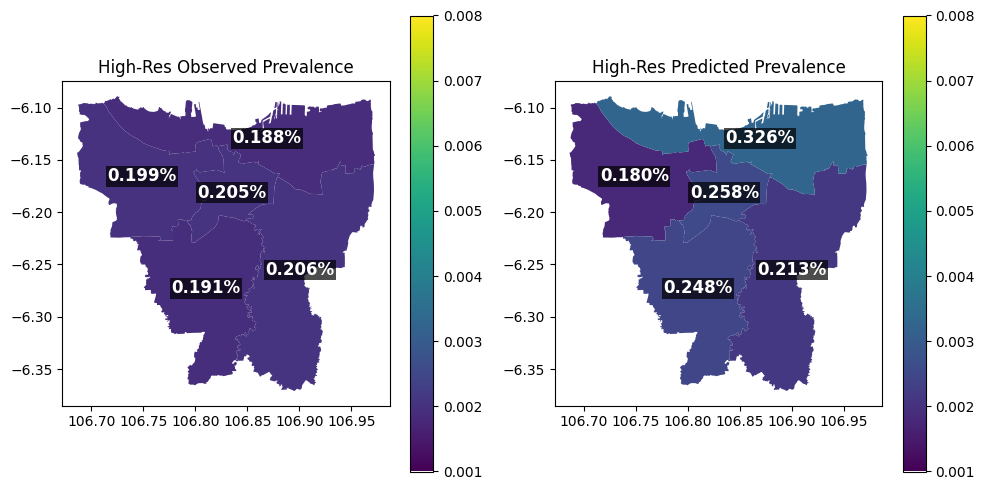

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("../data/processed/df_hi_jkt_2022_aggVAE_preds.csv")

# MCMC Inference (see which one produces the best metric (change manually))

In [165]:
model =  prev_model_vae_aggr

In [ ]:
#load MCMC objects
with open("../model weights/aggVAEPrev/mcmc_jkt_2023_23min_z40_prob0.85_treedepth15.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_31min_z40_prob0.9_treedepth15.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

#this one is batch size 5 for comparison with batch size 100 on 2023 dataset
with open("../model weights/aggVAEPrev/mcmc_jkt_2023_59min_z40_prob0.95_treedepth15.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_1min_z30_default.pkl", "rb") as f_4:
    mcmc_4 = pickle.load(f_4)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_3min_z40_batch5.pkl", "rb") as f_5:
    mcmc_5 = pickle.load(f_5)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_5min_z40_batch100.pkl", "rb") as f_6:
    mcmc_6 = pickle.load(f_6)

In [ ]:
#load the 2023 dataset
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2023
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

## Determine the best batch size, on 2023 dataset and default MCMC settings (for ease of computation)

### MCMC 5 (z = 40, n = 1000) - 2023, batch size 5

In [ ]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [ ]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_5.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_5,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_5.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.26      9.83     99.68     83.72    114.89     61.90      1.05
             b_hdi     -0.37      1.10     -0.33     -2.23      1.46      8.57      1.27
     b_pop_density      0.33      0.97      0.32     -1.21      1.91     35.71      1.10
           b_urban     -0.31      1.39     -0.11     -2.67      1.56      3.49      1.64
full_pred_cases[0]   1557.16     13.36   1560.03   1539.70   1576.54     11.21      1.40
full_pred_cases[1]    214.16    183.06    176.60    -11.40    429.02      2.31      2.86
full_pred_cases[2]    126.64    146.01      8.37    -13.09    326.79      2.54      2.22
full_pred_cases[3]    257.65    203.07    212.67    -11.23    490.37      2.24      3.12
full_pred_cases[4]    339.13    237.29    334.41    -13.65    586.18      2.16      3.75
full_pred_cases[5]    332.03    211.15    393.10     -9.20    543.93      2.27      3.02
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1557.161,13.365,1524.115,1576.543,4.291,4.554,18.0,17.0,1.19
pred_cases_out[1],214.156,183.055,-13.123,466.704,84.566,15.922,5.0,28.0,2.04
pred_cases_out[2],126.636,146.013,-18.084,353.392,63.819,8.875,7.0,36.0,1.61
pred_cases_out[3],257.647,203.067,-13.528,525.974,95.191,23.445,5.0,58.0,2.10
pred_cases_out[4],339.133,237.288,-15.512,635.931,113.318,40.538,5.0,27.0,2.10
pred_cases_out[5],332.030,211.151,-10.150,582.005,98.536,38.692,6.0,22.0,2.04
lp[0],1559.488,8.428,1543.307,1576.077,2.291,2.280,21.0,14.0,1.14
lp[1],214.571,182.556,0.000,465.974,84.342,15.970,5.0,4.0,2.23
lp[2],127.030,145.658,0.000,344.522,63.640,8.902,6.0,5.0,1.98
lp[3],257.442,203.123,0.000,525.424,95.288,23.453,5.0,4.0,2.24


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_5.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 5
Average ESS for all aggVAE-low effects : 5
Max r_hat for all aggVAE-low : 1.3799999952316284
Average ESS for all aggVAE-high effects : 4
Max r_hat for all aggVAE-high : 1.590000033378601


### MCMC 6 (z = 40, n = 1000) - 2023, batch size 100

In [ ]:
args["z_dim"] = 30
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e50_h50_z30.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [ ]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_6.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_6,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_6.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.24      9.90    100.09     83.21    115.97    750.00      1.00
             b_hdi      0.12      1.00      0.14     -1.66      1.63    286.63      1.01
     b_pop_density      0.07      1.01      0.07     -1.53      1.71    390.24      1.00
           b_urban      0.11      1.02      0.14     -1.59      1.72    261.76      1.01
full_pred_cases[0]   1561.61      8.55   1562.05   1548.64   1575.12    528.91      1.01
full_pred_cases[1]    401.71    111.46    401.85    221.37    586.26    153.74      1.01
full_pred_cases[2]    281.03    121.40    281.80     94.96    492.20    158.71      1.01
full_pred_cases[3]    452.69    111.12    453.59    274.88    638.40    152.26      1.01
full_pred_cases[4]    559.50    101.98    560.76    400.04    737.20    151.75      1.01
full_pred_cases[5]    522.66    101.76    522.32    360.77    696.49    157.25      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.608,8.548,1544.568,1577.866,0.370,0.374,598.0,575.0,1.01
pred_cases_out[1],401.708,111.463,192.986,604.072,8.790,4.509,162.0,287.0,1.01
pred_cases_out[2],281.028,121.398,57.448,507.012,9.375,4.537,167.0,297.0,1.01
pred_cases_out[3],452.687,111.125,258.690,666.797,8.801,4.500,160.0,260.0,1.01
pred_cases_out[4],559.500,101.984,371.597,747.594,8.109,4.072,160.0,271.0,1.01
pred_cases_out[5],522.660,101.760,338.918,715.924,7.952,4.137,164.0,276.0,1.01
lp[0],1561.816,6.121,1550.059,1573.676,0.190,0.198,1136.0,1144.0,1.01
lp[1],401.773,111.323,192.326,601.550,8.783,4.514,162.0,278.0,1.01
lp[2],280.964,121.179,58.716,508.813,9.366,4.536,168.0,304.0,1.01
lp[3],452.630,110.831,256.236,663.117,8.780,4.476,161.0,268.0,1.01


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_6.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 472
Average ESS for all aggVAE-low effects : 476
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 472
Max r_hat for all aggVAE-high : 1.0


## Determine the best target_accept_prob, setting tree depth = 20, on 2023 dataset

### MCMC 1 (z = 40, n = 1000 Inference, target accept prob = 0.85, tree depth 15) - 2023, batch size 5

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.01      9.70     99.87     84.51    115.72   3609.96      1.00
             b_hdi      0.08      1.02      0.08     -1.58      1.75   1460.67      1.00
     b_pop_density      0.08      1.02      0.08     -1.55      1.75   2591.65      1.00
           b_urban      0.05      1.01      0.03     -1.55      1.75   1555.27      1.00
full_pred_cases[0]   1562.00      8.06   1562.00   1548.86   1575.06   2861.36      1.00
full_pred_cases[1]    328.06    136.39    328.80     97.27    551.71    640.25      1.01
full_pred_cases[2]    192.13    138.94    190.00    -11.34    375.45    722.12      1.00
full_pred_cases[3]    387.86    141.02    392.14    158.52    619.72    653.50      1.01
full_pred_cases[4]    503.53    139.13    506.97    271.81    717.27    598.49      1.01
full_pred_cases[5]    473.46    137.01    463.61    262.52    679.28    593.84      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.999,8.059,1546.667,1578.896,0.152,0.298,3172.0,1583.0,1.02
pred_cases_out[1],328.063,136.390,85.323,629.426,5.378,3.757,649.0,628.0,1.00
pred_cases_out[2],192.125,138.936,-16.369,409.060,5.165,2.994,727.0,931.0,1.00
pred_cases_out[3],387.857,141.025,127.517,675.265,5.512,3.774,662.0,761.0,1.01
pred_cases_out[4],503.530,139.129,240.873,782.733,5.667,4.715,627.0,638.0,1.01
pred_cases_out[5],473.460,137.011,226.650,732.950,5.599,7.737,729.0,568.0,1.00
lp[0],1562.085,5.905,1550.519,1574.146,0.106,0.203,3418.0,1817.0,1.01
lp[1],328.052,136.223,0.000,540.643,5.376,3.764,646.0,609.0,1.00
lp[2],192.125,138.902,0.000,409.759,5.159,2.983,691.0,970.0,1.01
lp[3],387.998,140.696,126.688,671.645,5.504,3.784,661.0,664.0,1.01


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 805
Average ESS for all aggVAE-low effects : 819
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 802
Max r_hat for all aggVAE-high : 1.0099999904632568


In [181]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#calculate RMSE, MAE as percentage of average no. of districts
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["Cases"].values
    y_pred_d = group["pred_cases_num"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")

RMSE: 102.7880
MAE as % of average observed prevalence: 29.04%


### MCMC 2 (z = 40, n = 1000, target accept prob = 0.9, tree depth = 15) - year is 2023

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.01      9.62    100.00     83.39    115.08   2589.66      1.00
             b_hdi      0.03      1.00      0.04     -1.64      1.62   1361.65      1.00
     b_pop_density      0.07      0.99      0.07     -1.72      1.53   2691.22      1.00
           b_urban      0.04      1.01      0.04     -1.56      1.81   1177.84      1.00
full_pred_cases[0]   1561.71      7.99   1561.94   1549.13   1574.72   1885.27      1.00
full_pred_cases[1]    324.35    138.10    324.65     96.91    542.57    434.25      1.00
full_pred_cases[2]    190.59    139.72    184.32    -14.21    376.21    492.93      1.01
full_pred_cases[3]    385.45    142.98    387.88    148.58    606.22    443.60      1.00
full_pred_cases[4]    499.71    141.24    502.05    274.02    713.02    415.69      1.00
full_pred_cases[5]    465.99    133.54    455.03    248.61    653.35    447.20      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.707,7.994,1545.754,1577.814,0.183,0.380,2361.0,1179.0,1.02
pred_cases_out[1],324.347,138.098,63.302,598.177,6.533,5.281,469.0,580.0,1.00
pred_cases_out[2],190.594,139.721,-14.392,427.159,6.228,3.844,499.0,807.0,1.01
pred_cases_out[3],385.452,142.977,113.651,669.494,6.682,5.251,472.0,610.0,1.00
pred_cases_out[4],499.712,141.244,241.980,774.120,6.825,6.321,459.0,529.0,1.00
pred_cases_out[5],465.991,133.540,233.173,717.134,6.234,8.161,548.0,558.0,1.00
lp[0],1561.815,5.672,1551.341,1573.258,0.110,0.231,3056.0,1691.0,1.02
lp[1],324.399,138.147,0.000,533.418,6.542,5.282,466.0,569.0,1.00
lp[2],190.769,139.514,0.000,421.212,6.215,3.846,487.0,713.0,1.01
lp[3],385.324,142.915,114.318,670.423,6.683,5.228,469.0,617.0,1.00


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1117
Average ESS for all aggVAE-low effects : 1121
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 1117
Max r_hat for all aggVAE-high : 1.0099999904632568


In [ ]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["Cases"].values
    y_pred_d = group["pred_cases_num"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")

RMSE: 99.3886
MAE as % of average observed prevalence: 28.17%


### MCMC 3 (z = 40, n = 1000, target accept prob = 0.95, tree depth = 15) - year is 2023 - BEST!

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.01      9.62    100.00     83.39    115.08   2589.66      1.00
             b_hdi      0.03      1.00      0.04     -1.64      1.62   1361.65      1.00
     b_pop_density      0.07      0.99      0.07     -1.72      1.53   2691.22      1.00
           b_urban      0.04      1.01      0.04     -1.56      1.81   1177.84      1.00
full_pred_cases[0]   1561.71      7.99   1561.94   1549.13   1574.72   1885.27      1.00
full_pred_cases[1]    324.35    138.10    324.65     96.91    542.57    434.25      1.00
full_pred_cases[2]    190.59    139.72    184.32    -14.21    376.21    492.93      1.01
full_pred_cases[3]    385.45    142.98    387.88    148.58    606.22    443.60      1.00
full_pred_cases[4]    499.71    141.24    502.05    274.02    713.02    415.69      1.00
full_pred_cases[5]    465.99    133.54    455.03    248.61    653.35    447.20      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.707,7.994,1545.754,1577.814,0.183,0.380,2361.0,1179.0,1.02
pred_cases_out[1],324.347,138.098,63.302,598.177,6.533,5.281,469.0,580.0,1.00
pred_cases_out[2],190.594,139.721,-14.392,427.159,6.228,3.844,499.0,807.0,1.01
pred_cases_out[3],385.452,142.977,113.651,669.494,6.682,5.251,472.0,610.0,1.00
pred_cases_out[4],499.712,141.244,241.980,774.120,6.825,6.321,459.0,529.0,1.00
pred_cases_out[5],465.991,133.540,233.173,717.134,6.234,8.161,548.0,558.0,1.00
lp[0],1561.815,5.672,1551.341,1573.258,0.110,0.231,3056.0,1691.0,1.02
lp[1],324.399,138.147,0.000,533.418,6.542,5.282,466.0,569.0,1.00
lp[2],190.769,139.514,0.000,421.212,6.215,3.846,487.0,713.0,1.01
lp[3],385.324,142.915,114.318,670.423,6.683,5.228,469.0,617.0,1.00


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1117
Average ESS for all aggVAE-low effects : 1121
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 1117
Max r_hat for all aggVAE-high : 1.0099999904632568


In [ ]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["Cases"].values
    y_pred_d = group["pred_cases_num"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")

RMSE: 99.3886
MAE as % of average observed prevalence: 28.17%


In [ ]:
#this is the best parameters, so we download the predictions to be used
df_hi.to_csv("../data/processed/df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 4 (z = 30, n = 1000 Inference, target accept prob = 0.8, tree depth 10 (default) - bc alr converged, so using default MCMC settings is ok) - 2023, batch size 5

In [ ]:
args["z_dim"] = 30
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e50_h50_z30.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [ ]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_4.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_4,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_4.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.24      9.90    100.09     83.21    115.97    750.00      1.00
             b_hdi      0.12      1.00      0.14     -1.66      1.63    286.63      1.01
     b_pop_density      0.07      1.01      0.07     -1.53      1.71    390.24      1.00
           b_urban      0.11      1.02      0.14     -1.59      1.72    261.76      1.01
full_pred_cases[0]   1561.61      8.55   1562.05   1548.64   1575.12    528.91      1.01
full_pred_cases[1]    401.71    111.46    401.85    221.37    586.26    153.74      1.01
full_pred_cases[2]    281.03    121.40    281.80     94.96    492.20    158.71      1.01
full_pred_cases[3]    452.69    111.12    453.59    274.88    638.40    152.26      1.01
full_pred_cases[4]    559.50    101.98    560.76    400.04    737.20    151.75      1.01
full_pred_cases[5]    522.66    101.76    522.32    360.77    696.49    157.25      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.608,8.548,1544.568,1577.866,0.370,0.374,598.0,575.0,1.01
pred_cases_out[1],401.708,111.463,192.986,604.072,8.790,4.509,162.0,287.0,1.01
pred_cases_out[2],281.028,121.398,57.448,507.012,9.375,4.537,167.0,297.0,1.01
pred_cases_out[3],452.687,111.125,258.690,666.797,8.801,4.500,160.0,260.0,1.01
pred_cases_out[4],559.500,101.984,371.597,747.594,8.109,4.072,160.0,271.0,1.01
pred_cases_out[5],522.660,101.760,338.918,715.924,7.952,4.137,164.0,276.0,1.01
lp[0],1561.816,6.121,1550.059,1573.676,0.190,0.198,1136.0,1144.0,1.01
lp[1],401.773,111.323,192.326,601.550,8.783,4.514,162.0,278.0,1.01
lp[2],280.964,121.179,58.716,508.813,9.366,4.536,168.0,304.0,1.01
lp[3],452.630,110.831,256.236,663.117,8.780,4.476,161.0,268.0,1.01


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_4.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 472
Average ESS for all aggVAE-low effects : 476
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 472
Max r_hat for all aggVAE-high : 1.0


In [ ]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["Cases"].values
    y_pred_d = group["pred_cases_num"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")

RMSE: 149.9626
MAE as % of average observed prevalence: 51.72%


## Determine the best target_accept_prob on the 2022 dataset

In [ ]:
#load the mcmc data u want
with open("../model weights/aggVAE/mcmc_jkt_2022_30min_targetprob0.9.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAE/mcmc_jkt_2022_8min_prob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

In [ ]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



### prob 0.99

In [ ]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [ ]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.37     10.42     99.66     81.47    115.75    611.51      1.01
          b_hdi     -0.06      0.99     -0.05     -1.69      1.62    512.64      1.01
  b_pop_density      0.04      1.00      0.01     -1.54      1.77    884.54      1.01
        b_urban      0.00      0.98     -0.01     -1.54      1.69    415.14      1.03
  kernel_length      0.51      0.31      0.44      0.18      0.82    487.50      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    942.78      1.00
       log_f[0]      3.12      0.63      3.19      2.10      4.06      7.64      1.23
       log_f[1]      3.12      0.63      3.18      2.11      4.05      7.72      1.23
       log_f[2]      3.12      0.63      3.18      2.10      4.01      7.32      1.24
       log_f[3]      3.12      0.63      3.19      2.14      4.04      6.85      1.26
       log_f[4]      3.13      0.63      3.18      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1646.596,875.216,365.375,3185.032,306.871,85.655,9.0,120.0,1.37
pred_cases[1],368.961,213.365,-11.617,716.932,65.142,15.826,11.0,175.0,1.28
pred_cases[2],234.845,154.303,-31.739,510.296,35.624,5.730,20.0,268.0,1.16
pred_cases[3],422.398,236.873,-10.304,815.463,74.667,16.149,10.0,150.0,1.31
pred_cases[4],528.612,283.825,45.214,1041.124,96.893,27.116,9.0,151.0,1.37
pred_cases[5],472.321,253.130,52.169,928.174,83.932,22.753,10.0,159.0,1.33
lp[0],1646.142,873.557,363.205,3159.308,306.922,86.535,9.0,122.0,1.37
lp[1],368.010,205.532,0.000,683.969,64.043,16.406,11.0,165.0,1.30
lp[2],234.612,146.278,0.000,473.000,36.148,5.650,17.0,230.0,1.19
lp[3],422.696,231.447,0.000,786.191,74.361,15.825,10.0,155.0,1.33


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 5
Average ESS for all aggGPE-low effects : 5
Max r_hat for all aggGP-low : 1.440000057220459
Average ESS for all aggGP-high effects : 5
Max r_hat for all aggGP-high : 1.4199999570846558


### prob 0.95

In [ ]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [ ]:
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.12     10.21    100.13     83.53    116.50   1222.95      1.00
          b_hdi      0.02      1.00      0.03     -1.53      1.70    826.60      1.00
  b_pop_density      0.03      0.99      0.03     -1.54      1.76   1158.81      1.00
        b_urban     -0.01      1.00      0.00     -1.68      1.62    456.56      1.02
  kernel_length      0.48      0.29      0.41      0.17      0.80    568.81      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1342.08      1.00
       log_f[0]      2.92      0.66      2.88      1.84      4.00     12.26      1.15
       log_f[1]      2.91      0.65      2.88      1.88      4.03     12.24      1.15
       log_f[2]      2.90      0.66      2.88      1.87      4.00     12.19      1.15
       log_f[3]      2.90      0.66      2.88      1.88      3.97     12.26      1.15
       log_f[4]      2.90      0.65      2.90      1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1389.527,967.823,202.085,2644.281,215.843,334.338,16.0,40.0,1.18
pred_cases[1],325.968,218.443,-22.035,629.538,40.600,50.289,30.0,50.0,1.10
pred_cases[2],215.144,153.676,-37.819,476.227,13.655,17.457,208.0,128.0,1.05
pred_cases[3],374.063,247.043,-12.040,744.591,49.999,56.876,24.0,53.0,1.12
pred_cases[4],463.677,296.847,34.291,925.182,63.250,80.407,20.0,48.0,1.15
pred_cases[5],414.112,264.316,3.071,775.125,52.846,71.015,25.0,45.0,1.12
lp[0],1390.295,966.739,223.409,2664.244,215.666,333.828,17.0,40.0,1.18
lp[1],326.203,212.418,0.000,596.356,40.077,51.748,29.0,50.0,1.11
lp[2],215.877,144.277,0.000,432.452,16.134,18.786,120.0,104.0,1.06
lp[3],374.010,240.870,0.000,695.706,49.782,57.963,23.0,53.0,1.13


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 23
Average ESS for all aggGPE-low effects : 21
Max r_hat for all aggGP-low : 1.149999976158142
Average ESS for all aggGP-high effects : 23
Max r_hat for all aggGP-high : 1.159999966621399


In [ ]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

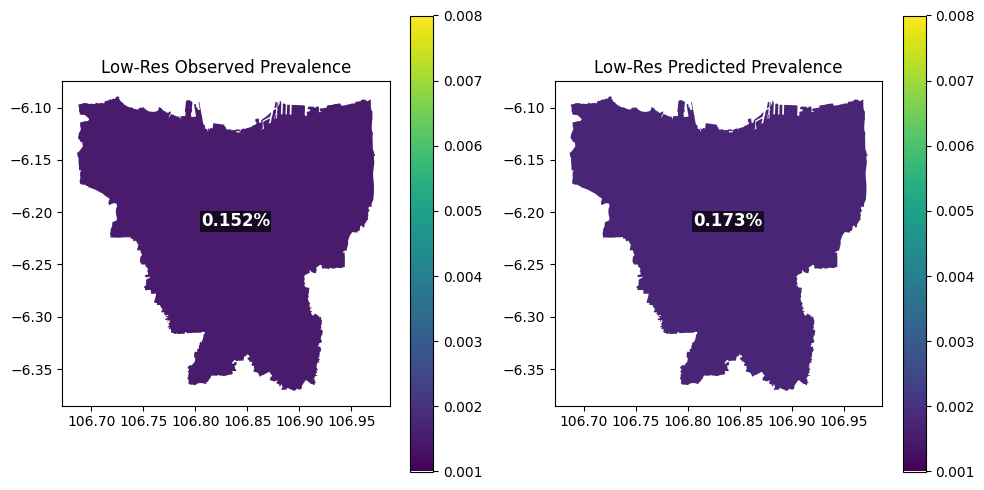

In [ ]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

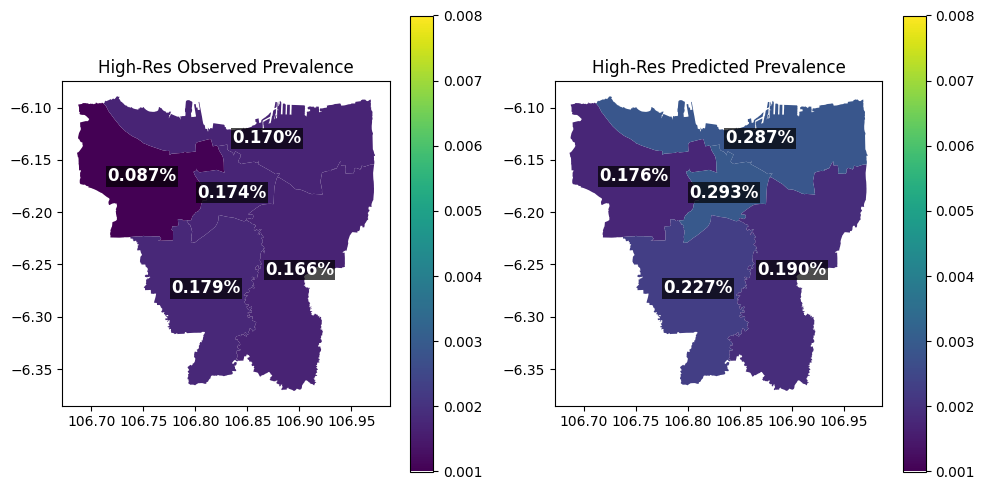

In [ ]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2022.csv")